# NLP on two companies from twitter posts.
#### This project is an approach to apply Natural Language Processing on twitter posts to get insight of the topics that interest the most people, public opinion and sentiment analysis about two different companies in the same sector. "Electric Vehicles"

### Importing Libraries.

In [327]:
# Pandas: This library will used to create and work with dataframes.
import pandas as pd 
# Matplotlib: Used to plot graphics. 
import matplotlib.pyplot as plt
# Seaborn: Used to better style and improve graphics. 
import seaborn as sns
# Numpy for mathematic calculations. 
import numpy as np
#Tweepy: Used to work with the Twitter API.
import tweepy as tw
#ConfigParser: Used to get credentials for the twitter API.
import configparser as cp
#NLTK its used to pre-proccess text and regex its used to filter that text.
import nltk, re
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = stopwords.words('english')
custom_stopwords = ["Tesla", "tesla", "TSLA", "tsla", "Rivian", "rivian", "RIVN", "rivn"]
normalizer = WordNetLemmatizer()
#Library to count words
from collections import Counter
# library to build wordclouds
from wordcloud import WordCloud
# NLTK to analice sentiment. 
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
#Another Library to perform sentiment analisis.
from textblob import Word, TextBlob
# NLTK library to build ngrams.
from nltk.util import ngrams
# NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.
import networkx as nx
from pyvis.network import Network
# Built on top of plotly.js, plotly.py is a high-level, declarative charting library.
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
# Library to handle dates in different formats. 
import datetime

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Importing and authenticating API credentials from the config file. 

In [203]:
config =  cp.ConfigParser()
config.read("config.ini")

api_key = config["twitter"]["api_key"]
api_key_secret = config["twitter"]["api_key_secret"]
access_token = config["twitter"]["access_token"]
access_token_secret = config["twitter"]["access_token_secret"]

# Authentication

auth = tw.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tw.API(auth)

### Funtions to work with in this project.

In [324]:
# Functions to perform data extraction from twitter.

def scrape(words, numtweet):
# We are using .Cursor() to search
# through twitter for the required tweets.
# The number of tweets can be
# restricted using .items(number of tweets)
    tweets = tw.Cursor(api.search_tweets,
                               words, 
                               lang="en",
                               tweet_mode='extended').items(numtweet)


# .Cursor() returns an iterable object. Each item in
# the iterator has various attributes
# that you can access to
# get information about each tweet
    list_tweets = [tweet for tweet in tweets]
 
# we will iterate over each tweet in the
# list for extracting information about each tweet
    columns=['tweet_date','tweets']
    data = []
    for tweet in list_tweets:
        tweet_date = tweet.created_at
# Retweets can be distinguished by
# a retweeted_status attribute,
# in case it is an invalid reference,
# except block will be executed
        try:
            tweets = tweet.retweeted_status.full_text
        except AttributeError:
            tweets = tweet.full_text
            data.append([tweet_date, tweets])
# Creating DataFrame using pandas
    df = pd.DataFrame(data, columns=columns)
    print(words + " Data.")
    return df 

#Functions to preproccess text.
def get_part_of_speech(word):
  probable_part_of_speech = wordnet.synsets(word)
  pos_counts = Counter()
  pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
  pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
  pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
  pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
  most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
  return most_likely_part_of_speech

def preprocess_text(text, custom_stopword):
  cleaned = re.sub(r'(\W+)|(http\S+)', ' ', text).lower()
  tokenized = word_tokenize(cleaned)
  normalized = [normalizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized if token not in stop_words]
  normalized = [token for token in normalized if token not in custom_stopword]
  return normalized

# Cleaning text. 
def clean_text(text, custom_stopword):
  cleaned = re.sub(r'(\W+)|(http\S+)', ' ', text).lower()
  cleaned = " ".join(word for word in cleaned.split() if word not in stop_words)
  cleaned = " ".join(word for word in cleaned.split() if word not in custom_stopwords)
  cleaned = " ".join(normalizer.lemmatize(word, get_part_of_speech(word)) for word in cleaned.split())
  return cleaned

# Function to build and plot a WordCloud.
def wordcloud(str1, str2):
    wordcloud1 = WordCloud (
                    background_color = 'white',
                    width = 620,
                    height = 410
                        ).generate(' '.join(str1))
    wordcloud2 = WordCloud (
                    background_color = 'white',
                    width = 620,
                    height = 410
                        ).generate(' '.join(str2))
#plot the wordcloud object
    plt.figure(figsize = (20,17))
    plt.subplot(1,2,1)
    plt.title("Ford WordCloud")
    plt.imshow(wordcloud1, interpolation='bilInear')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title("Tesla WordCloud")
    plt.imshow(wordcloud2, interpolation='bilInear')
    plt.axis('off')
    plt.show()

#Sentiment finder
def sentiment(text):
    score = sia.polarity_scores(text)
    pos = score["pos"]
    neg = score["neg"]
    if pos > neg:
        sentiment = "positive"
    elif neg > pos:
        sentiment = "negative"
    else:
        sentiment = "neutral"
    return sentiment


### Getting the data from twitter.

In [322]:
startDate = datetime.datetime(2022, 3, 4, 0, 0, 0).replace(tzinfo=utc)
endDate =   datetime.datetime(2022, 4, 3, 0, 0, 0).replace(tzinfo=utc)
def search(word, numtweet):
    tweets = tw.Cursor(api.search_tweets, 
                          word, tweet_mode='extended').items(numtweet)
    list_tweets = [tweet for tweet in tweets]
    columns=['tweet_date','tweets']
    data = []
    for tweet in list_tweets:
        if tweet.created_at < endDate and tweet.created_at > startDate:
            tweet_date = tweet.created_at
        try:
            tweets = tweet.retweeted_status.full_text
        except AttributeError:
            tweets = tweet.full_text
            data.append([tweet_date, tweets])
    df = pd.DataFrame(data, columns=columns)
    return df 

search("TSLA", 10)

"""while (tmpTweets[-1].created_at > startDate):
    tmpTweets = api.user_timeline(username, max_id = tmpTweets[-1].id)
    for tweet in tmpTweets:
        if tweet.created_at < endDate and tweet.created_at > startDate:
            tweets.append(tweet)"""



UnboundLocalError: local variable 'tweet_date' referenced before assignment

In [325]:

tesla = scrape("TSLA", 2000)
rivian = scrape("RIVN", 2000)

TSLA Data.


TooManyRequests: 429 Too Many Requests
88 - Rate limit exceeded

### Preproccessing the data for further analisys.

In [206]:
tesla_preprocess = preprocess_text("".join(tesla.tweets), custom_stopwords)
rivian_preprocess = preprocess_text("".join(rivian.tweets), custom_stopwords)

### Counting words with bag of words

In [207]:
tesla_bow = Counter(tesla_preprocess)
rivian_bow = Counter(rivian_preprocess)

print("\nThen most frequent words and number of occurrences for Tesla according to Bag-of-Words:")
most_common_tesla = tesla_bow.most_common(10)
print(most_common_tesla)
print("\nTen most frequent words and number of occurrences for Rivian according to Bag-of-Words:")
most_common_rivian = rivian_bow.most_common(10)
print(most_common_rivian)


Then most frequent words and number of occurrences for Tesla according to Bag-of-Words:
[('mention', 79), ('stock', 52), ('elonmusk', 45), ('price', 44), ('spy', 40), ('4', 38), ('5', 36), ('btc', 34), ('1', 32), ('qqq', 32)]

Ten most frequent words and number of occurrences for Rivian according to Bag-of-Words:
[('lcid', 128), ('nio', 104), ('amc', 85), ('gme', 80), ('muln', 72), ('2022', 64), ('get', 63), ('put', 63), ('ev', 62), ('amzn', 61)]


### Building a WordCloud

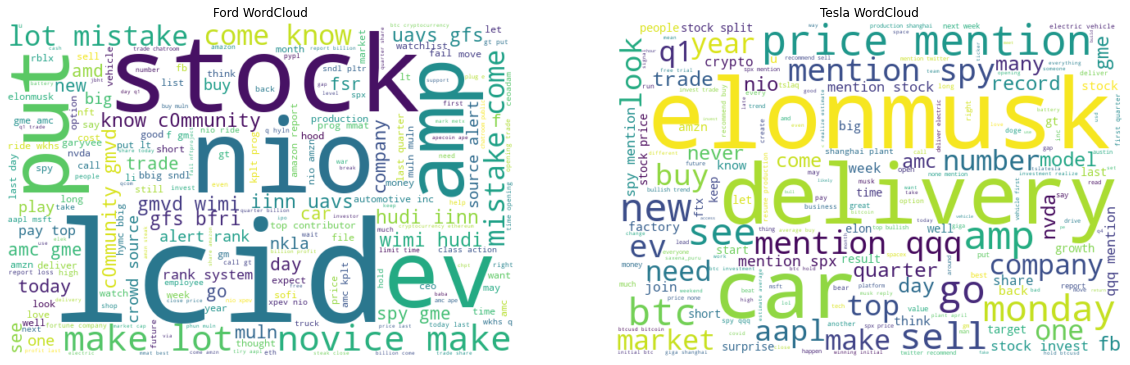

In [255]:
wordcloud(rivian_preprocess, tesla_preprocess)

### Finding the sentiment of each tweet using nltk SentimentIntensityAnalyzer

In [209]:
# In this case we just need to clean the data and create a new column with it.
tesla["clean_tweet"] = tesla["tweets"].apply(lambda x: clean_text(x, custom_stopwords))
rivian["clean_tweet"] = rivian["tweets"].apply(lambda x: clean_text(x, custom_stopwords))
# Now we can apply the sentiment function and create a new column with it.
tesla["sentiment"] = tesla["clean_tweet"].apply(sentiment)
rivian["sentiment"] = rivian["clean_tweet"].apply(sentiment)
rivian.head()


,tweet_date,tweets,clean_tweet,sentiment
0,2022-04-03 04:36:38+00:00,@stonkstradamus @unusual_whales Same will keep...,stonkstradamus unusual_whales keep watch lcid ...,negative
1,2022-04-03 03:33:06+00:00,"$RIVN For a limited time,, we are opening our ...",limit time opening trade chatroom public,neutral
2,2022-04-03 03:29:47+00:00,@vr_tonio @unusual_whales Wasn't it an IPO des...,vr_tonio unusual_whales ipo desperation get ev...,negative
3,2022-04-03 02:53:37+00:00,$TSLA 431K shares in #darkpool at $1084.59 wor...,431k share darkpool 1084 59 worth 466mil repor...,positive
4,2022-04-03 02:24:42+00:00,$MULN look at the market cap of other EV compa...,muln look market cap ev company like nio fsr l...,positive


### Sentiment count per company.

In [210]:
# Total sentiment count
sentiment_count_tesla =  tesla.groupby('sentiment')['sentiment'].count()
sentiment_count_rivian = rivian.groupby('sentiment')['sentiment'].count()
#Creating a df with that count to plot. 
total_sentiments_tesla = sentiment_count_tesla.to_frame()
total_sentiments_tesla.rename(columns={"sentiment":"count"}, inplace=True)
total_sentiments_tesla.reset_index(inplace=True)
total_sentiments_tesla["company"] = "tesla"

total_sentiments_rivian = sentiment_count_rivian.to_frame()
total_sentiments_rivian.rename(columns={"sentiment":"count"}, inplace=True)
total_sentiments_rivian.reset_index(inplace=True)
total_sentiments_rivian["company"] = "rivian"

total_sentiments = [total_sentiments_tesla, total_sentiments_rivian]

total_sentiments = pd.concat(total_sentiments, ignore_index=True)

print("Total sentiment count of Rivian:")
print(total_sentiments_rivian)
print("\nTotal sentiment count of Tesla: ")
print(total_sentiments_tesla)

# Sentiment count by day
day_tesla_sentiment_count = tesla.groupby([pd.Grouper(key='tweet_date', axis=0, 
                      freq='D', sort=True), "sentiment"])['sentiment'].count()
day_rivian_sentiment_count = rivian.groupby([pd.Grouper(key='tweet_date', axis=0, 
                      freq='D', sort=True), "sentiment"])['sentiment'].count()
#day_tesla_sentiment_count

Total sentiment count of Rivian:
  sentiment  count company
0  negative    140  rivian
1   neutral    108  rivian
2  positive    279  rivian

Total sentiment count of Tesla: 
  sentiment  count company
0  negative     56   tesla
1   neutral    120   tesla
2  positive    182   tesla


### Sentiments BarCharts

In [211]:
"""#Plot with matplotlib

plt.figure(figsize=(15,10))
plt.suptitle("Total sentiments Count")
plt.subplot(1,2,1)
plt.title("Sentiment count Rivian")
sns.barplot(x="sentiment", y="count", data=total_sentiments_rivian, palette="Spectral")
plt.subplot(1,2,2)
plt.title("Sentiment count Tesla")
sns.barplot(x="sentiment", y="count", data=total_sentiments_tesla, palette="Spectral")
plt.show()
plt.clf()

# Plot with Plotly
fig = make_subplots(rows=1, cols=2, subplot_titles=("Tesla", "Rivian"))

fig.add_trace(
    go.Bar(x=total_sentiments_tesla["sentiment"], y=total_sentiments_tesla["count"], marker_color=("#de425b", "#9fc08f", "#488f31")),
    row=1, col=2)
fig.update_xaxes(title_text="Sentiment")
fig.update_yaxes(title_text="Count")
fig.update_layout(height=800, width=1000, title_text="Total sentiments Counts", showlegend=False)
fig.add_trace(
    go.Bar(x=total_sentiments_rivian["sentiment"], y=total_sentiments_rivian["count"], marker_color=("#de425b", "#9fc08f", "#488f31")),
    row=1, col=1)
fig.show()"""

# Plot with Plotly
colours = {
    "tesla": "#EF3A4C",
    "rivian": "#3EC1CD"
}

fig = px.histogram(total_sentiments, x="sentiment", y="count",
             color='company', barmode='group',
             height=800, title="Total sentiments comparison",  color_discrete_map=colours)
fig.show()



### Finding the sentiment of each tweet using TextBlob
##### Polarity: range from -1 to 1, being -1 the most negative sentiment and 1 the most positive.
##### Subjectivity: quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information.

In [212]:
tesla["polarity"] = tesla["clean_tweet"].apply(lambda x: TextBlob(x).sentiment[0])
tesla["subjectivity"] = tesla["clean_tweet"].apply(lambda x: TextBlob(x).sentiment[1])
rivian["polarity"] = rivian["clean_tweet"].apply(lambda x: TextBlob(x).sentiment[0])
rivian["subjectivity"] = rivian["clean_tweet"].apply(lambda x: TextBlob(x).sentiment[1])
tesla.head()

,tweet_date,tweets,clean_tweet,sentiment,polarity,subjectivity
0,2022-04-03 08:00:58+00:00,$TSLA Bears aren’t talking they don’t want all...,bear talk want good news trend anymore bad,positive,5.551115e-17,0.633333
1,2022-04-03 08:00:28+00:00,Top 5 trending #redditarmy #stocks in the last...,top 5 trend redditarmy stock last 4 hour sym c...,positive,1.333333e-01,0.322222
2,2022-04-03 07:59:09+00:00,@TeslaAndDoge He can I invest in $TSLA stock,teslaanddoge invest stock,neutral,0.000000e+00,0.000000
3,2022-04-03 07:58:27+00:00,"Tesla Reports 310,048 Deliveries For Q1 2022, ...",report 310 048 delivery q1 2022 model 3 delive...,neutral,0.000000e+00,0.000000
4,2022-04-03 07:57:57+00:00,When time comes to build a @Tesla $TSLA Giga-f...,time come build giga factory africa kenya perf...,positive,1.000000e+00,1.000000


### Mean and Median of Polarity and subjectivity by brand.

In [213]:
print("Tesla")
display(tesla[["polarity", "subjectivity"]].agg([np.mean, np.median]))
print("Rivian")
rivian[["polarity", "subjectivity"]].agg([np.mean, np.median])

Tesla


,polarity,subjectivity
mean,0.116859,0.338672
median,0.000000,0.333333


Rivian


,polarity,subjectivity
mean,0.095088,0.320153
median,0.000000,0.300000


### Visualizing the moving average of the sentiments.

In [246]:
# Building dataframes for the visualization. 
tesla_ma = tesla[["tweet_date", "polarity"]]
tesla_ma = tesla_ma.sort_values(by="tweet_date", ascending=True)
tesla_ma["MA Polarity"] = tesla_ma.polarity.rolling(10, min_periods=3).mean()
print(tesla_ma.tweet_date.max())
print(tesla_ma.tweet_date.min())
rivian_ma = rivian[["tweet_date", "polarity"]]
rivian_ma = rivian_ma.sort_values(by="tweet_date", ascending=True)
rivian_ma["MA Polarity"] = rivian_ma.polarity.rolling(10, min_periods=3).mean()
print(rivian_ma.tweet_date.max())
print(rivian_ma.tweet_date.min())
print(rivian_ma)


2022-04-03 08:00:58+00:00
2022-04-03 03:25:03+00:00
2022-04-03 04:36:38+00:00
2022-03-30 23:10:05+00:00
                   tweet_date  polarity  MA Polarity
526 2022-03-30 23:10:05+00:00    0.0000          NaN
525 2022-03-30 23:27:00+00:00    0.2375          NaN
524 2022-03-30 23:43:10+00:00    0.4000     0.212500
523 2022-03-31 00:02:55+00:00    0.4400     0.269375
522 2022-03-31 00:02:55+00:00    0.0000     0.215500
..                        ...       ...          ...
4   2022-04-03 02:24:42+00:00    0.0000    -0.041667
3   2022-04-03 02:53:37+00:00   -0.0500    -0.046667
2   2022-04-03 03:29:47+00:00    0.2125    -0.025417
1   2022-04-03 03:33:06+00:00    0.0000    -0.025417
0   2022-04-03 04:36:38+00:00    0.0000    -0.020417

[527 rows x 3 columns]


In [266]:
"""#Plotting both graph with matplotib. 

fig, ax = plt.subplots(2, 1, figsize=(16,10))
ax[0].plot(tesla_ma["tweet_date"], tesla_ma["MA Polarity"], color="#cc0000")
ax[0].set_title("Tesla polarity moving average")

ax[1].plot(rivian_ma["tweet_date"], rivian_ma["MA Polarity"], color="#2A6BAC")
ax[1].set_title("Rivian polarity moving average")

plt.show()
plt.clf()"""

#Plotting both graph with Plotly. 

colours = {
    "tesla": "#EF3A4C",
    "rivian": "#3EC1CD"
}
fig1 = px.line(tesla_ma, x="tweet_date", y="MA Polarity", title="Tesla polarity moving average",  color_discrete_map=colours)

fig1.add_trace(go.Scatter(x = rivian_ma["tweet_date"], y = rivian_ma["MA Polarity"], name = 'Rivian'))

fig1.update_xaxes(rangeslider_visible=True)

fig1.show()

"""fig2 = px.line(rivian_ma, x="tweet_date", y="MA Polarity", title="Rivian polarity moving average")
fig2.update_traces(line_color='#2A6BAC')
fig2.show()"""

'fig2 = px.line(rivian_ma, x="tweet_date", y="MA Polarity", title="Rivian polarity moving average")\nfig2.update_traces(line_color=\'#2A6BAC\')\nfig2.show()'

### Visualizing Subjectivity and Polarity 

In [281]:
#Plotting both graph with Matplotlib. 

"""plt.figure(figsize=(15,10))
plt.suptitle("Polarity and subjectivity scatter plot")
plt.subplot(1,2,1)
plt.title("Tesla")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
for i in range(len(tesla)):
    plt.scatter(x=tesla["polarity"][i], y=tesla["subjectivity"][i])
plt.subplot(1,2,2)
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
for i in range(len(rivian)):
    plt.scatter(x=rivian["polarity"][i], y=rivian["subjectivity"][i])
plt.title("Rivian")
plt.show()"""

#Plotting both graph with Plotly. 

"""fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=tesla["polarity"], y=tesla["subjectivity"], mode="markers", name="Tesla"),
    row=1, col=2)
fig.add_trace(
    go.Scatter(x=rivian["polarity"], y=rivian["subjectivity"], mode="markers", name="Rivian"),
    row=1, col=1)
fig.update_xaxes(title_text="Polarity")
fig.update_yaxes(title_text="Subjectivity")
fig.update_layout(height=800, width=1000, title_text="Polarity and subjectivity scatter plot")
fig.show()"""


trace1 = go.Scatter(
    x = rivian["polarity"], y = rivian["subjectivity"],
    name="Rivian",
    marker=dict(
        color='rgb(34,163,192)'
               ), mode='markers'
)
trace2 = go.Scatter(
    x = tesla["polarity"], y = tesla["subjectivity"],
    name='Tesla', mode='markers'

)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update(height = 900, width = 700, title = "Polarity and subjectivity scatter plot", xaxis_title="Polarity",
    yaxis_title="Subjectivity")

fig.show()


'fig = px.scatter(tesla, x="polarity", y="subjectivity",\n             height=800, title="Total sentiments comparison",  color_discrete_map=colours)\nfig.add_trace(go.Scatter(x = rivian["polarity"], y = rivian["subjectivity"], name = \'Rivian\'))\nfig.show()'

### Counting the most used words by sentiment. 

In [217]:
# Joining and preprocessing all tweets based on sentiment.
tesla_preprocess_positive = preprocess_text("".join(tesla["tweets"][tesla["sentiment"] == "positive"]), custom_stopwords)
tesla_preprocess_negative = preprocess_text("".join(tesla["tweets"][tesla["sentiment"] == "negative"]), custom_stopwords)

rivian_preprocess_positive = preprocess_text("".join(rivian["tweets"][rivian["sentiment"] == "positive"]), custom_stopwords)
rivian_preprocess_negative = preprocess_text("".join(rivian["tweets"][rivian["sentiment"] == "negative"]), custom_stopwords)

#Counting the words of each sentiment. 
tesla_bow_positive = Counter(tesla_preprocess_positive)
tesla_bow_negative = Counter(tesla_preprocess_negative)

rivian_bow_positive = Counter(rivian_preprocess_positive)
rivian_bow_negative = Counter(rivian_preprocess_negative)

# Printing the most common words by sentiment. 
print("\nThen most frequent positive words and number of occurrences for Tesla according to Bag-of-Words:")
most_common_tesla_positive = tesla_bow_positive.most_common(10)
print(most_common_tesla_positive)

print("\nThen most frequent negative words and number of occurrences for Tesla according to Bag-of-Words:")
most_common_tesla_negative = tesla_bow_negative.most_common(10)
print(most_common_tesla_negative)

print("\nTen most frequent positive words and number of occurrences for Rivian according to Bag-of-Words:")
most_common_rivian_positive = rivian_bow_positive.most_common(10)
print(most_common_rivian_positive)

print("\nTen most frequent negative words and number of occurrences for Rivian according to Bag-of-Words:")
most_common_rivian_negative = rivian_bow_negative.most_common(10)
print(most_common_rivian_negative)


Then most frequent positive words and number of occurrences for Tesla according to Bag-of-Words:
[('mention', 78), ('price', 38), ('stock', 34), ('spy', 31), ('btc', 29), ('1', 27), ('qqq', 27), ('5', 26), ('4', 26), ('buy', 21)]

Then most frequent negative words and number of occurrences for Tesla according to Bag-of-Words:
[('elonmusk', 14), ('amp', 9), ('stock', 8), ('delivery', 8), ('sell', 6), ('company', 6), ('monday', 6), ('buy', 5), ('spy', 4), ('tslaq', 4)]

Ten most frequent positive words and number of occurrences for Rivian according to Bag-of-Words:
[('lcid', 74), ('nio', 50), ('get', 49), ('share', 46), ('trade', 41), ('put', 41), ('alert', 40), ('amc', 39), ('50', 38), ('gt', 38)]

Ten most frequent negative words and number of occurrences for Rivian according to Bag-of-Words:
[('know', 39), ('make', 34), ('lot', 33), ('come', 33), ('mistake', 31), ('gfs', 31), ('novice', 30), ('c0mmunity', 30), ('gmvd', 30), ('wimi', 30)]


### 2-Grams and 3-Grams are the combinations of two or three words used on twitter.

In [218]:
# Bigrams
bigrams_tesla = ngrams(tesla_preprocess, 2)
bigrams_tesla_count = Counter(bigrams_tesla)

print("Five most frequent word sequences and the number of occurrences in Tesla according to Bigrams:")
print(bigrams_tesla_count.most_common(5))

bigrams_rivian = ngrams(rivian_preprocess, 2)
bigrams_rivian_count = Counter(bigrams_rivian)

print("Five most frequent word sequences and the number of occurrences in Rivian according to Bigrams:")
print(bigrams_rivian_count.most_common(5))

#Threegram
threegram_tesla = ngrams(tesla_preprocess, 3)
threegrams_tesla_count = Counter(threegram_tesla)

print("Five most frequent word sequences and the number of occurrences in Tesla according to threegrams:")
print(threegrams_tesla_count.most_common(5))

threegrams_rivian = ngrams(rivian_preprocess, 3)
threegrams_rivian_count = Counter(threegrams_rivian)

print("Five most frequent word sequences and the number of occurrences in Rivian according to threegrams:")
print(threegrams_rivian_count.most_common(5))

Five most frequent word sequences and the number of occurrences in Tesla according to Bigrams:
[(('stock', 'invest'), 12), (('spy', 'mention'), 12), (('qqq', 'mention'), 12), (('stock', 'split'), 9), (('stock', 'price'), 9)]
Five most frequent word sequences and the number of occurrences in Rivian according to Bigrams:
[(('novice', 'make'), 30), (('make', 'lot'), 30), (('lot', 'mistake'), 30), (('mistake', 'come'), 30), (('come', 'know'), 30)]
Five most frequent word sequences and the number of occurrences in Tesla according to threegrams:
[(('deliver', '310', '048'), 6), (('310', '048', 'electric'), 6), (('048', 'electric', 'vehicle'), 6), (('electric', 'vehicle', 'first'), 6), (('vehicle', 'first', 'quarter'), 6)]
Five most frequent word sequences and the number of occurrences in Rivian according to threegrams:
[(('novice', 'make', 'lot'), 30), (('make', 'lot', 'mistake'), 30), (('lot', 'mistake', 'come'), 30), (('mistake', 'come', 'know'), 30), (('come', 'know', 'c0mmunity'), 30)]


### 2 grams based on sentiments. 

In [219]:


# Positive Bigrams
bigrams_positive_tesla = ngrams(tesla_preprocess_positive, 2)
bigrams_positive_tesla_count = Counter(bigrams_positive_tesla)

print("Five most frequent positive word sequences in Tesla and the number of occurrences according to Bigrams:")
print(bigrams_positive_tesla_count.most_common(5))

# Negative Bigrams
bigrams_negative_tesla = ngrams(tesla_preprocess_negative, 2)
bigrams_negative_tesla_count = Counter(bigrams_negative_tesla)

print("Five most frequent negative word sequences in Tesla and the number of occurrences according to Bigrams:")
print(bigrams_negative_tesla_count .most_common(5))

# Positive Bigrams
bigrams_positive_rivian = ngrams(rivian_preprocess_positive, 2)
bigrams_positive_rivian_count = Counter(bigrams_positive_rivian)

print("Five most frequent positive word sequences in Rivian and the number of occurrences according to Bigrams:")
print(bigrams_positive_rivian_count.most_common(5))

# Negative Bigrams
bigrams_negative_rivian = ngrams(rivian_preprocess_negative, 2)
bigrams_negative_rivian_count = Counter(bigrams_negative_rivian)

print("Five most frequent negative word sequences in Rivian and the number of occurrences according to Bigrams:")
print(bigrams_negative_rivian_count.most_common(5))

Five most frequent positive word sequences in Tesla and the number of occurrences according to Bigrams:
[(('stock', 'invest'), 12), (('spy', 'mention'), 12), (('qqq', 'mention'), 12), (('top', '5'), 8), (('stock', 'price'), 7)]
Five most frequent negative word sequences in Tesla and the number of occurrences according to Bigrams:
[(('stock', 'split'), 3), (('add', 'use'), 2), (('black', 'swan'), 2), (('swan', 'event'), 2), (('covid', 'break'), 2)]
Five most frequent positive word sequences in Rivian and the number of occurrences according to Bigrams:
[(('crowd', 'source'), 19), (('source', 'alert'), 19), (('alert', 'rank'), 19), (('rank', 'system'), 19), (('system', 'get'), 19)]
Five most frequent negative word sequences in Rivian and the number of occurrences according to Bigrams:
[(('novice', 'make'), 30), (('make', 'lot'), 30), (('lot', 'mistake'), 30), (('mistake', 'come'), 30), (('come', 'know'), 30)]


### 3 grams based on sentiments. 

In [220]:
# Positive Threegrams
threegrams__positive_tesla = ngrams(tesla_preprocess_positive, 3)
threegrams_positive_tesla_count = Counter(threegrams__positive_tesla)

print("Five most frequent positive word sequences in Tesla and the number of occurrences according to Threegram:")
print(threegrams_positive_tesla_count.most_common(5))

# Negative Threegrams
threegrams_negative_tesla = ngrams(tesla_preprocess_negative, 3)
threegrams_negative_tesla_count = Counter(threegrams_negative_tesla)

print("Five most frequent negative word sequences in Tesla and the number of occurrences according to Threegram:")
print(threegrams_negative_tesla_count.most_common(5))

# Positive Threegrams
threegrams_positive_rivian = ngrams(rivian_preprocess_positive, 3)
threegrams_positive_rivian_count = Counter(threegrams_positive_rivian)

print("Five most frequent positive word sequences in Rivian and the number of occurrences according to Threegram:")
print(threegrams_positive_rivian_count.most_common(5))

# Negative Threegrams
threegrams_negative_rivian = ngrams(rivian_preprocess_negative, 3)
threegrams_negative_rivian_count = Counter(threegrams_negative_rivian)

print("Five most frequent negative word sequences in Rivian and the number of occurrences according to Threegram:")
print(threegrams_negative_rivian_count.most_common(5))

Five most frequent positive word sequences in Tesla and the number of occurrences according to Threegram:
[(('top', 'stock', 'price'), 6), (('stock', 'price', '1'), 6), (('price', '1', '084'), 6), (('1', '084', '59'), 6), (('084', '59', 'mention'), 6)]
Five most frequent negative word sequences in Tesla and the number of occurrences according to Threegram:
[(('black', 'swan', 'event'), 2), (('covid', 'break', 'every'), 2), (('break', 'every', 'record'), 2), (('every', 'record', 'quarterly'), 2), (('record', 'quarterly', 'stock'), 2)]
Five most frequent positive word sequences in Rivian and the number of occurrences according to Threegram:
[(('crowd', 'source', 'alert'), 19), (('source', 'alert', 'rank'), 19), (('alert', 'rank', 'system'), 19), (('rank', 'system', 'get'), 19), (('system', 'get', 'pay'), 19)]
Five most frequent negative word sequences in Rivian and the number of occurrences according to Threegram:
[(('novice', 'make', 'lot'), 30), (('make', 'lot', 'mistake'), 30), (('lot

### Building a new dataframe for network explorations. 

In [221]:

bigram_df_tesla = pd.DataFrame(bigrams_tesla_count.most_common(20),
                             columns=['bigram', 'count'])

bigram_df_rivian = pd.DataFrame(bigrams_rivian_count.most_common(20),
                             columns=['bigram', 'count'])

# Create dictionary of bigrams and their counts
t = bigram_df_tesla.set_index('bigram').T.to_dict('records')
r = bigram_df_rivian.set_index('bigram').T.to_dict('records')


### Network Analysis

In [328]:
# Create network plot Tesla
Gt = nx.Graph()

# Create connections between nodes
for k, v in t[0].items():
    Gt.add_edge(k[0], k[1], weight=(v * 10))

Gt2 = Network(height='750px', width='100%', bgcolor='#222222', font_color='white')
Gt2.from_nx(Gt)
neighbor_map_t = Gt2.get_adj_list()
for node in Gt2.nodes:
    node["value"] = len(neighbor_map_t[node["id"]])  
    
Gt2.show("network_map_tesla.html")

# Create network plot Rivian
Gr = nx.Graph()

# Create connections between nodes
for k, v in r[0].items():
    Gr.add_edge(k[0], k[1], weight=(v * 10))

Gr2 = Network(height='750px', width='100%', bgcolor='#222222', font_color='white')
Gr2.from_nx(Gr)
neighbor_map_r = Gr2.get_adj_list()
for node in Gr2.nodes:
    node["value"] = len(neighbor_map_r[node["id"]])
    
Gr2.show("network_map_rivian.html")